In [1]:
!pip install transformers > /dev/null

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score

from transformers import RobertaTokenizer, RobertaModel, PreTrainedTokenizer

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from copy import deepcopy
import matplotlib.pyplot as plt

from typing import NoReturn, Tuple, List
from tqdm import tqdm, trange
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
BATCH_SIZE = 64
MAX_LEN = 128
DEVICE = "cuda"

In [39]:
data = pd.read_csv('/content/drive/MyDrive/NLP/tweets/train_tweets.csv').drop(['id'], axis=1)
# train_data = pd.read_csv('/content/drive/MyDrive/NLP/tweets/train_data.csv')
# val_data = pd.read_csv('/content/drive/MyDrive/NLP/tweets/val_data.csv')
# test_data = pd.read_csv('/content/drive/MyDrive/NLP/tweets/test_data.csv')

In [40]:
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


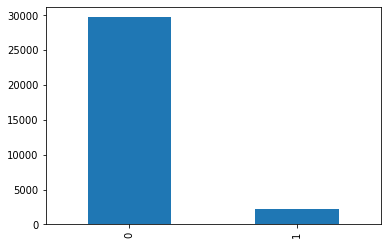

In [41]:
data['label'].value_counts().plot.bar()
plt.show()

# Balancing out the data
- объединение случайных твитов класса 1
- добавление копий твитов
- downsampling доминирующего класса 0

In [42]:
data.shape

(31962, 2)

In [45]:
def concat_samples(data: pd.DataFrame, class_: int, n_new_samples: int, 
                   min_n_concat: int = 2, max_n_concat: int = 3) -> pd.DataFrame:
    for _ in range(n_new_samples):
        samples = data.loc[data['label'] == class_]\
        .sample(np.random.randint(min_n_concat, max_n_concat + 1))['tweet']\
        .to_list()

        new_entry = {'label': 1, 
                    'tweet': ' '.join(samples)}
        data = data.append(new_entry, ignore_index=True)
    return data

def copy_samples(data: pd.DataFrame, class_: int, 
                 n_new_samples: int, **kwargs) -> pd.DataFrame:
    samples = data.loc[data['label'] == class_]\
        .sample(n_new_samples)
    data = data.append(samples)
    return data

def bootstrap(data: pd.DataFrame, class_: int, n_new_samples: int, 
              min_n_concat: int = 2, max_n_concat: int = 3) -> pd.DataFrame:
    methods = [concat_samples, copy_samples]
    for _ in range(n_new_samples):
        method = methods[np.random.randint(0, 2)]
        data = method(data, class_, 1, min_n_concat=2, max_n_concat=3)
    return data

In [46]:
data = bootstrap(data, 1, 5000)

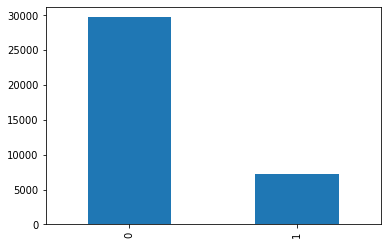

In [47]:
data['label'].value_counts().plot.bar()
plt.show()

In [48]:
data['label'].value_counts()

0    29720
1     7242
Name: label, dtype: int64

In [49]:
negative = data.loc[data['label'] == 0].sample(7500)
positive = data.loc[data['label'] == 1]
new_data = pd.concat([negative, positive])
# shuffling
new_data = new_data.sample(frac=1)

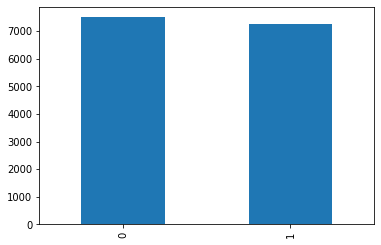

In [50]:
new_data['label'].value_counts().plot.bar()
plt.show()

# Train / Val / Test split

In [51]:
val_data = new_data.sample(frac=0.2)
train_data = new_data.drop(val_data.index)

test_data = val_data.sample(frac=0.5)
val_data = val_data.drop(test_data.index)

In [52]:
train_data.to_csv('/content/drive/MyDrive/NLP/tweets/train_data.csv')
val_data.to_csv('/content/drive/MyDrive/NLP/tweets/val_data.csv')
test_data.to_csv('/content/drive/MyDrive/NLP/tweets/test_data.csv')

In [53]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

In [54]:
def prepare_dataloader(dataframe: pd.DataFrame, 
                       tokenizer: PreTrainedTokenizer) -> DataLoader:
    encodings = tokenizer(
            dataframe['tweet'].to_list(), 
            return_token_type_ids=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors="pt").to(DEVICE)
    labels = torch.tensor(dataframe['label'].to_numpy(), dtype=torch.long).to(DEVICE)
    dataset = TensorDataset(encodings["input_ids"], 
                           encodings["attention_mask"], labels)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [55]:
train_dataloader = prepare_dataloader(train_data, tokenizer)
val_dataloader = prepare_dataloader(val_data, tokenizer)
test_dataloader = prepare_dataloader(test_data, tokenizer)

# Модель

In [56]:
class RobertaClassifier(nn.Module):
    def __init__(self, hidden_size: int, n_classes: int, dropout: float):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.fc1 = nn.Linear(768, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, n_classes)
    
    def forward(self, input_ids: torch.Tensor, 
                attention_mask: torch.Tensor) -> torch.Tensor:
        z = self.roberta(input_ids, attention_mask)
        z = self.fc1(z.pooler_output)
        z = self.relu(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z
    
    def get_labels(self, input_ids: torch.Tensor, 
                   attention_mask: torch.Tensor) -> torch.Tensor:
        z = self.forward(input_ids, attention_mask)
        return torch.argmax(z, dim=1)

In [57]:
def accuracy(output: torch.Tensor, labels: torch.Tensor) -> float:
    return torch.sum(torch.argmax(output, dim=1) == labels).item() / len(labels)

In [59]:
def train(model: nn.Module, train_dataloader: DataLoader, 
          val_dataloader: DataLoader, lr: float = 3e-4, 
          epochs: int = 5, freeze_roberta: bool = True, 
          min_val_loss: float = np.inf, 
          save_path: str = '/content/drive/MyDrive/NLP/tweets/roberta.pt') -> NoReturn:
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    min_val_loss = min_val_loss
    
    # freezing roberta
    if freeze_roberta:
        for param in model.roberta.parameters():
            param.requires_grad = False

    for epoch in range(epochs):
        total_train_loss = 0
        total_train_acc = 0

        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            input_ids, attention_mask, labels = batch
            model.zero_grad()

            output = model.forward(input_ids, attention_mask)
            loss = loss_func(output, labels)
            total_train_loss += loss.item()
            total_train_acc += accuracy(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        avg_train_loss = total_train_loss / (i + 1)
        avg_train_acc = total_train_acc / (i + 1)

        total_val_loss = 0
        total_val_acc = 0

        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_dataloader, position=0, leave=True)):
                input_ids, attention_mask, labels = batch
                output = model.forward(input_ids, attention_mask)
                loss = loss_func(output, labels)
                total_val_loss += loss.item()
                total_val_acc += accuracy(output, labels)
            
        avg_val_loss = total_val_loss / (i + 1)
        avg_val_acc = total_val_acc / (i + 1)
        
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)

        print(f"Epoch {epoch + 1}: train loss {avg_train_loss:.3f} val loss {avg_val_loss:.3f} val acc {avg_val_acc:.3f}")
            

In [60]:
def test(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    total_acc = 0
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, position=0, leave=True)):
            input_ids, attention_mask, labels = batch
            output = model.forward(input_ids, attention_mask)
            total_acc += accuracy(output, labels)

    avg_acc = total_acc / (i + 1)
    return avg_acc

In [61]:
model = RobertaClassifier(hidden_size=768, n_classes=2, dropout=0.3).to(DEVICE)

In [62]:
acc_before_training = test(model, test_dataloader)

100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


In [63]:
train(model, train_dataloader, val_dataloader, lr=3e-5, epochs=65)

  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1: train loss 0.688 val loss 0.683 val acc 0.697


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2: train loss 0.678 val loss 0.673 val acc 0.735


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3: train loss 0.666 val loss 0.655 val acc 0.792


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 4: train loss 0.651 val loss 0.645 val acc 0.753


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 5: train loss 0.633 val loss 0.625 val acc 0.804


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 6: train loss 0.613 val loss 0.602 val acc 0.773


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 7: train loss 0.593 val loss 0.586 val acc 0.801


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 8: train loss 0.574 val loss 0.554 val acc 0.833


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 9: train loss 0.552 val loss 0.534 val acc 0.803


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 10: train loss 0.532 val loss 0.508 val acc 0.865


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 11: train loss 0.519 val loss 0.531 val acc 0.775


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 12: train loss 0.503 val loss 0.478 val acc 0.816


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 13: train loss 0.487 val loss 0.469 val acc 0.859


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 14: train loss 0.474 val loss 0.454 val acc 0.833


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 15: train loss 0.463 val loss 0.433 val acc 0.857


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 16: train loss 0.451 val loss 0.425 val acc 0.847


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 17: train loss 0.441 val loss 0.415 val acc 0.871


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 18: train loss 0.433 val loss 0.401 val acc 0.881


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 19: train loss 0.427 val loss 0.390 val acc 0.845


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 20: train loss 0.414 val loss 0.375 val acc 0.880


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 21: train loss 0.410 val loss 0.357 val acc 0.880


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 22: train loss 0.403 val loss 0.354 val acc 0.869


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 23: train loss 0.396 val loss 0.341 val acc 0.886


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 24: train loss 0.393 val loss 0.354 val acc 0.857


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 25: train loss 0.388 val loss 0.333 val acc 0.873


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 26: train loss 0.380 val loss 0.335 val acc 0.872


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 27: train loss 0.384 val loss 0.375 val acc 0.833


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 28: train loss 0.377 val loss 0.316 val acc 0.887


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 29: train loss 0.370 val loss 0.317 val acc 0.880


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 30: train loss 0.368 val loss 0.319 val acc 0.885


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 31: train loss 0.361 val loss 0.308 val acc 0.895


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 32: train loss 0.362 val loss 0.300 val acc 0.896


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 33: train loss 0.357 val loss 0.290 val acc 0.896


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 34: train loss 0.358 val loss 0.315 val acc 0.880


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 35: train loss 0.357 val loss 0.311 val acc 0.894


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 36: train loss 0.355 val loss 0.282 val acc 0.899


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 37: train loss 0.349 val loss 0.303 val acc 0.877


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 38: train loss 0.347 val loss 0.284 val acc 0.897


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 39: train loss 0.344 val loss 0.381 val acc 0.855


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 40: train loss 0.345 val loss 0.291 val acc 0.882


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 41: train loss 0.344 val loss 0.269 val acc 0.897


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 42: train loss 0.342 val loss 0.285 val acc 0.893


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 43: train loss 0.339 val loss 0.271 val acc 0.896


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 44: train loss 0.336 val loss 0.273 val acc 0.899


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 45: train loss 0.344 val loss 0.284 val acc 0.898


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 46: train loss 0.338 val loss 0.262 val acc 0.900


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 47: train loss 0.330 val loss 0.261 val acc 0.900


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 48: train loss 0.335 val loss 0.270 val acc 0.891


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 49: train loss 0.332 val loss 0.268 val acc 0.893


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 50: train loss 0.330 val loss 0.315 val acc 0.860


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 51: train loss 0.329 val loss 0.256 val acc 0.901


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 52: train loss 0.331 val loss 0.254 val acc 0.904


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 53: train loss 0.323 val loss 0.269 val acc 0.891


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 54: train loss 0.326 val loss 0.258 val acc 0.897


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 55: train loss 0.324 val loss 0.253 val acc 0.900


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 56: train loss 0.320 val loss 0.248 val acc 0.904


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 57: train loss 0.317 val loss 0.259 val acc 0.896


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 58: train loss 0.322 val loss 0.244 val acc 0.906


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 59: train loss 0.322 val loss 0.254 val acc 0.900


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 60: train loss 0.318 val loss 0.248 val acc 0.907


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 61: train loss 0.318 val loss 0.245 val acc 0.904


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 62: train loss 0.320 val loss 0.249 val acc 0.900


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 63: train loss 0.321 val loss 0.287 val acc 0.864


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 64: train loss 0.315 val loss 0.241 val acc 0.904


100%|██████████| 24/24 [00:19<00:00,  1.20it/s]

Epoch 65: train loss 0.318 val loss 0.258 val acc 0.902


In [64]:
train(model, train_dataloader, val_dataloader, lr=3e-5, 
      epochs=5, freeze_roberta=False, min_val_loss=0.25)

  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1: train loss 0.313 val loss 0.240 val acc 0.908


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2: train loss 0.315 val loss 0.283 val acc 0.866


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3: train loss 0.314 val loss 0.238 val acc 0.906


  0%|          | 0/185 [00:00<?, ?it/s]

Epoch 4: train loss 0.311 val loss 0.235 val acc 0.910


100%|██████████| 24/24 [00:19<00:00,  1.20it/s]

Epoch 5: train loss 0.310 val loss 0.244 val acc 0.904


In [66]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/tweets/roberta.pt'))

<All keys matched successfully>

In [67]:
acc_after_training = test(model, test_dataloader)

100%|██████████| 24/24 [00:19<00:00,  1.20it/s]


# Precision-Recall Curve

In [69]:
def get_pr_values(model: nn.Module, dataloader: 
                  DataLoader, class_: int) -> Tuple[List, List]:
    softmax = nn.Softmax(dim=1)
    precisions, recalls = [], []
    thresholds = np.linspace(0., 1., 10)

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, position=0, leave=True)):
            input_ids, attention_mask, labels = batch
            if i == 0:
                output = softmax(model.forward(input_ids, attention_mask))
                all_labels = deepcopy(labels)
            else:
                out = softmax(model.forward(input_ids, attention_mask))
                output = torch.cat((output, out), dim=0)
                all_labels = torch.cat((all_labels, labels), dim=0)
    
    for th in thresholds:
        pred = [(1 if x[class_] >= th else 0) for x in output]
        pr = precision_score(all_labels.cpu(), pred, average='binary', pos_label=class_, zero_division=1)
        rec = recall_score(all_labels.cpu(), pred, average='binary', pos_label=class_)
        precisions.append(pr)
        recalls.append(rec)
    
    return precisions, recalls
            

In [70]:
precisions_train, recalls_train = get_pr_values(model, train_dataloader, 1)
precisions_val, recalls_val = get_pr_values(model, val_dataloader, 1)
precisions_test, recalls_test = get_pr_values(model, test_dataloader, 1)

100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


In [71]:
def plot_pr_curve(recalls_test: List, precisions_test: List, 
                  recalls_val: List = None, 
                  precisions_val: List = None,
                  recalls_train: List = None, 
                  precisions_train: List = None) -> NoReturn:

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(recalls_test, precisions_test, c='r', label="test")
    if recalls_val is not None and precisions_val is not None:
        ax.plot(recalls_val, precisions_val, c='b', label="val")
    if recalls_train is not None and precisions_train is not None:
        ax.plot(recalls_train, precisions_train, c='black', label="train")
    ax.plot([0, 1], [1, 0], linestyle="--", c='orange')

    ax.margins(0)
    ax.set_xticks(np.arange(0., 1., 0.1))
    ax.set_yticks(np.arange(0., 1., 0.1))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("PR-Curve")
    plt.legend()
    plt.show()

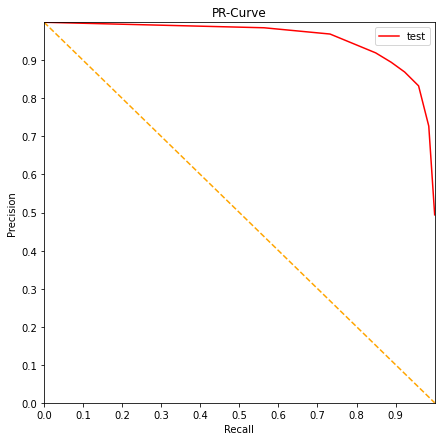

In [72]:
plot_pr_curve(recalls_test, precisions_test)

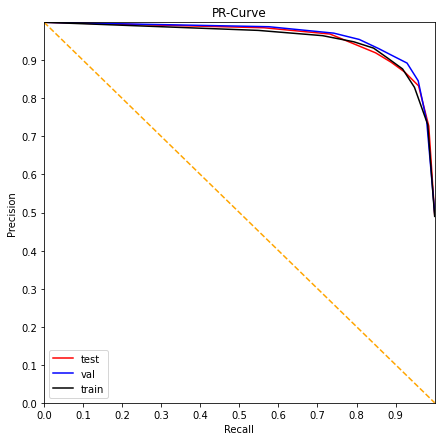

In [73]:
plot_pr_curve(recalls_test, precisions_test, 
              recalls_val, precisions_val, recalls_train, precisions_train)

# Финальные титры



In [68]:
print("Точность на тестовых данных:")
print(f"до обучения: {acc_before_training:.2f}")
print(f"последняя сохраненная модель после обучения: {acc_after_training:.2f}")

Точность на тестовых данных:
до обучения: 0.49
последняя сохраненная модель после обучения: 0.90


Обученная модель показывает результат лучше случайной (необученной) классификации.


С уменьшением порога классификации (от 1 до 0) precision уменьшается, а recall растет, то есть больше твитов начинает попадать в класс 1, но при этом среди них появляется и много твитов класса 0. Минимальный precision показывает отношение класса 1 ко всем элементам (в нашем случае около 0.5, так как выборка была сбалансирована)

Выбор порога зависит от того, что важнее: точно классифицировать как можно больше расистских/сексистских твитов, захватив с ними и нейтральные, или брать только те, в которых модель максимально уверена, упуская некоторые негативные твиты из-за меньшей уверенности модели.